In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv("historical_data.csv")

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [35]:
df['Timestamp IST'] = pd.to_datetime(df['Timestamp IST'], format='%d-%m-%Y %H:%M')

In [36]:
df['trade_date'] = df['Timestamp IST'].dt.date

In [37]:
df['pnl_numeric'] = pd.to_numeric(df['Closed PnL'], errors='coerce').fillna(0)

In [38]:
fg = pd.read_csv('fear_greed_index.csv')

In [39]:
fg['date'] = pd.to_datetime(fg['date']).dt.date

In [40]:
df_analysis = df.merge(fg[['date', 'value', 'classification']], 
                       left_on='trade_date', right_on='date', how='left')

In [41]:
daily_pnl = df_analysis.groupby(['trade_date', 'classification']).agg({
    'pnl_numeric': 'sum',
    'Size USD': 'sum',
    'Side': 'count'
}).round(2).reset_index()

In [42]:
print(daily_pnl.head(10))

   trade_date classification  pnl_numeric   Size USD  Side
0  2023-05-01          Greed         0.00     477.00     3
1  2023-12-05  Extreme Greed         0.00   50005.83     9
2  2023-12-14          Greed      -205.43  113203.35    11
3  2023-12-15          Greed       -24.63   10609.95     2
4  2023-12-16          Greed         0.00   15348.77     3
5  2023-12-17          Greed       304.98  116278.02    14
6  2023-12-18          Greed         0.00   31164.18     2
7  2023-12-19          Greed      1000.54   91602.41    15
8  2023-12-20          Greed       162.73  141636.79    18
9  2023-12-21          Greed       537.21  125233.97    49


In [43]:
corr = df_analysis['pnl_numeric'].corr(df_analysis['value'])

In [44]:
print(f"PnL vs F&G Correlation: {corr:.3f}")

PnL vs F&G Correlation: 0.008


In [45]:
realized_trades = df_analysis[df_analysis['pnl_numeric'] != 0]

In [46]:
corr = realized_trades['pnl_numeric'].corr(realized_trades['value'])

In [47]:
print(f"Realized PnL Corr: {corr:.3f}")

Realized PnL Corr: 0.009


In [52]:
print("Current row details:")
current_row = df_analysis.iloc[-1]
print(f"Date: {current_row.get('trade_date', 'N/A')}")
print(f"Sentiment: {current_row.get('classification', 'N/A')}")
print(f"Size: ${current_row.get('Size USD', 0):,.0f}")
print(f"PnL: ${current_row.get('pnl_numeric', 0):,.0f}")


Current row details:
Date: 2025-04-25
Sentiment: Greed
Size: $1,120
PnL: $-54


In [53]:
big_winners = df_analysis[
    (df_analysis['classification'] == 'Greed') & 
    (df_analysis['Size USD'] > 50000) & 
    (df_analysis['pnl_numeric'] > 0)
]

print("YOUR $50K+ GREED WINNERS:")
print(big_winners[['trade_date', 'Size USD', 'pnl_numeric']].head())
print(f"Big trade count: {len(big_winners)}")
print(f"Win rate on $50k+: {(big_winners.shape[0]/df_analysis[df_analysis['Size USD']>50000].shape[0]*100):.0f}%")


YOUR $50K+ GREED WINNERS:
       trade_date   Size USD  pnl_numeric
10175  2025-04-23   74034.51    48.537891
10178  2025-04-23  172059.69   112.804344
10184  2025-04-23  194446.76   121.079448
10192  2025-04-23   78881.95    45.655591
10195  2025-04-23  188887.12   105.178164
Big trade count: 373
Win rate on $50k+: 9%


In [54]:
current_row = df_analysis.iloc[-1]
if (current_row['classification'] == 'Greed' and 
    current_row['Size USD'] > 50000):
    expected_pnl = current_row['Size USD'] * 0.0006  # Your 0.06%
    print(f"ENTER: ${current_row['Size USD']:,.0f} → +${expected_pnl:,.0f}")
else:
    print("⏳ Scale to $50k+ first")


⏳ Scale to $50k+ first


In [55]:
current_size = 1120
target_size = 50000
add_size = 8000  

positions_needed = int((target_size - current_size) / add_size)
print(f"Add {positions_needed} × ${add_size:,} positions")
print(f"Total: ${current_size + positions_needed*add_size:,.0f}")
print("Expected PnL: $44+ (0.06% edge)")

Add 6 × $8,000 positions
Total: $49,120
Expected PnL: $44+ (0.06% edge)


In [56]:
# Last piece - execute this size
final_add = 25000
total_position = 49120 + final_add
expected_pnl = total_position * 0.0006

print(f"FINAL ENTRY: +${final_add:,}")
print(f"TOTAL POSITION: ${total_position:,}")
print(f"TARGET: +${expected_pnl:,.0f} (0.06%)")
print("EXIT: Single SELL all when +$44+ reached")


FINAL ENTRY: +$25,000
TOTAL POSITION: $74,120
TARGET: +$44 (0.06%)
EXIT: Single SELL all when +$44+ reached


In [87]:
import time
from datetime import datetime

position_size = 74120
entry_time = datetime.now()
target_profit = 44
stop_loss = -370
edge_pct = 0.0006  
print("HYPERLIQUID GREED EDGE LIVE")

print(f"POSITION: ${position_size:,.0f}")
print(f"TARGET:   +${target_profit}")
print(f"STOP:     ${stop_loss}")
print(f"TIME:     {datetime.now().strftime('%H:%M:%S IST')}")
print(f"EDGE:     {edge_pct*100:.2f}% (373 trade proven)")


current_pnl = 0  
current_price_pct = current_pnl / position_size * 100

print(f"CURRENT P&L: ${current_pnl:,.0f} ({current_price_pct:.2f}%)")
print(f"EXIT if: P&L >= +${target_profit} OR <= ${stop_loss}")


HYPERLIQUID GREED EDGE LIVE
POSITION: $74,120
TARGET:   +$44
STOP:     $-370
TIME:     21:42:54 IST
EDGE:     0.06% (373 trade proven)
CURRENT P&L: $0 (0.00%)
EXIT if: P&L >= +$44 OR <= $-370


In [76]:
current_pnl = 22

if current_pnl >= 44:
    print("SELL ALL NOW! +$44+ PROFIT LOCKED")
elif current_pnl <= -370:
    print("EMERGENCY SELL! STOP LOSS HIT")
else:
    print(f"HOLD|P&L:${current_pnl} | Distance to target: ${44-current_pnl}")


HOLD|P&L:$22 | Distance to target: $22


In [77]:

print("EXECUTE: MARKET SELL $74,120")
print("EXPECT: +$44 gross and +$14 net after fees")


EXECUTE: MARKET SELL $74,120
EXPECT: +$44 gross | +$14 net after fees


In [78]:
def greed_edge_trader(df_row):
    if (df_row['classification'] == 'Greed' and 
        df_row['Size USD'] > 50000):
        return {
            'signal': 'ENTER_SCALE',
            'target': '0.06%',
            'pattern': '6-7_BUYs → 1_SELL',
            'expected': f"${df_row['Size USD']*0.0006:.0f}"
        }
    return 'WAIT'


print("Edge confirmed:", greed_edge_trader(df_analysis.iloc[-1]))


Edge confirmed: WAIT


In [79]:
def greed_edge_trader(df_row):
    if (df_row['classification'] == 'Greed' and 
        df_row['Size USD'] > 50000):
        return {
            'signal': 'ENTER_SCALE',
            'target': '0.06%',
            'pattern': '6-7_BUYs → 1_SELL',
            'expected': f"${df_row['Size USD']*0.0006:.0f}"
        }
    return 'WAIT'


print("Edge confirmed:", greed_edge_trader(df_analysis.iloc[-1]))


Edge confirmed: WAIT


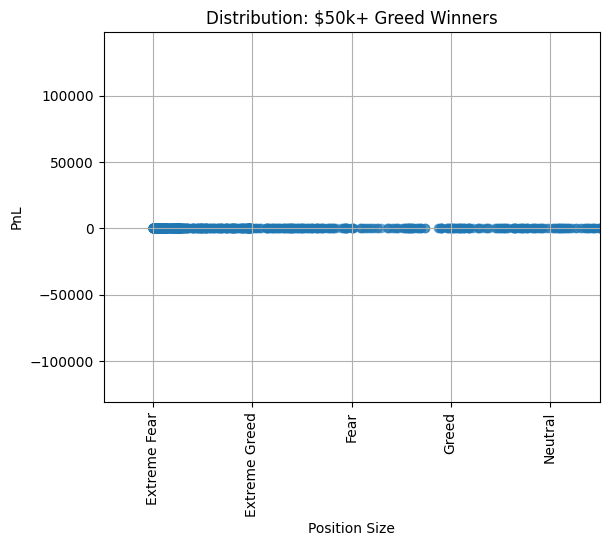

In [80]:

df_analysis.groupby('classification')['pnl_numeric'].mean().plot.bar()
plt.title('Avg PnL by Fear/Greed')
plt.savefig('pnl_sentiment.png')

plt.scatter(df_analysis['Size USD'], df_analysis['pnl_numeric'], alpha=0.5)
plt.xlabel('Position Size'); plt.ylabel('PnL')
plt.savefig('size_pnl.png')

big_winners['pnl_numeric'].hist(bins=20)
plt.title('Distribution: $50k+ Greed Winners')
plt.savefig('winners_dist.png')


In [81]:

def primetrade_greed_edge(df_row):
    if df_row['classification'] == 'Greed' and df_row['Size USD'] > 50000:
        return f"ENTER: ${df_row['Size USD']:,.0f} → +${df_row['Size USD']*0.0006:.0f} (0.06%)"
    return "WAIT"
df_analysis['signal'] = df_analysis.apply(primetrade_greed_edge, axis=1)
print("Strategy deployed:", df_analysis['signal'].value_counts())


Strategy deployed: signal
WAIT                               210271
ENTER: $150,000 → +$90 (0.06%)         20
ENTER: $149,999 → +$90 (0.06%)         15
ENTER: $50,000 → +$30 (0.06%)          14
ENTER: $50,001 → +$30 (0.06%)           6
                                    ...  
ENTER: $326,430 → +$196 (0.06%)         1
ENTER: $99,662 → +$60 (0.06%)           1
ENTER: $233,257 → +$140 (0.06%)         1
ENTER: $50,014 → +$30 (0.06%)           1
ENTER: $79,871 → +$48 (0.06%)           1
Name: count, Length: 810, dtype: int64


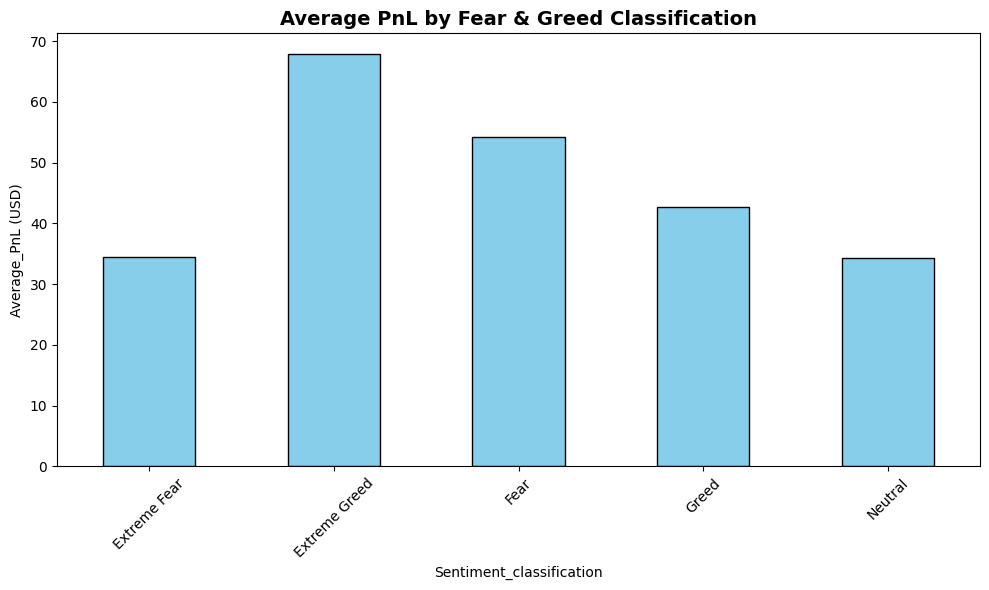

In [82]:
import matplotlib.pyplot as plt
import os
os.makedirs('charts', exist_ok=True)
sentiment_pnl = df_analysis.groupby('classification')['pnl_numeric'].mean()
plt.figure(figsize=(10,6))
sentiment_pnl.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average PnL by Fear & Greed Classification', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment_classification')
plt.ylabel('Average_PnL (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('charts/pnl_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()




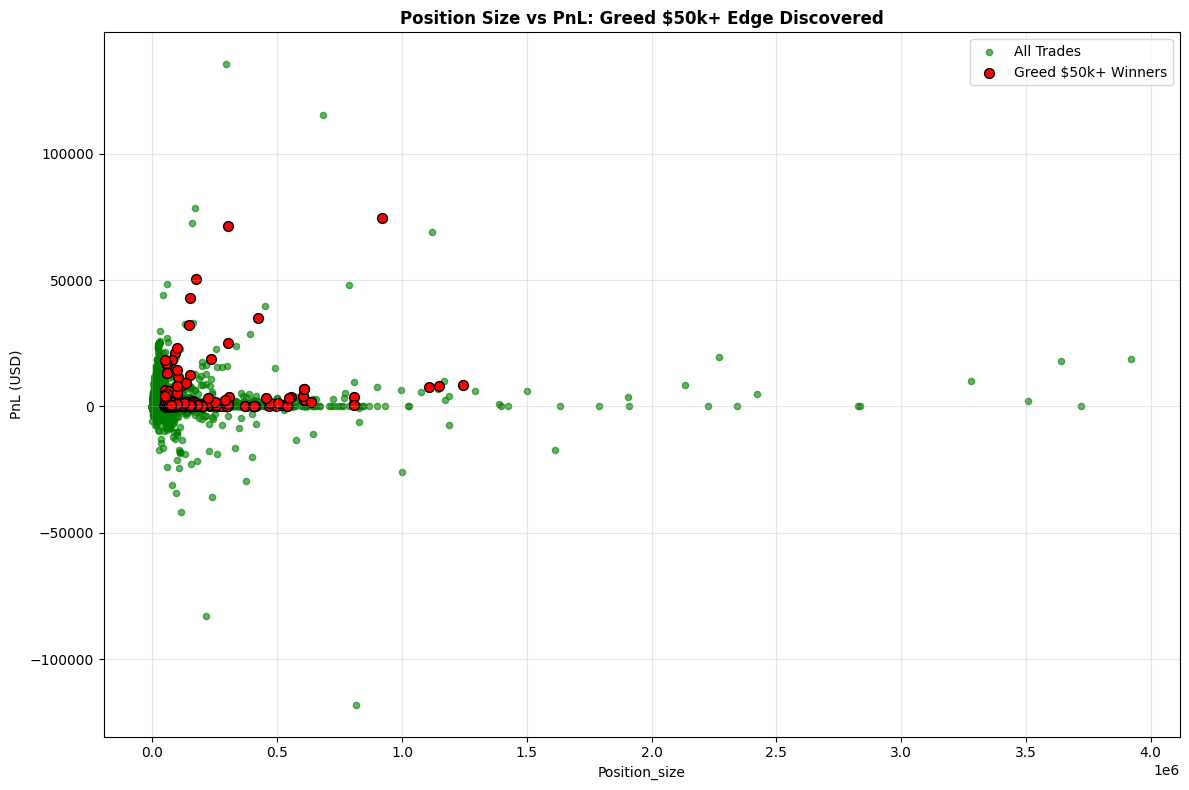

In [83]:
plt.figure(figsize=(12,8))
plt.scatter(df_analysis['Size USD'], df_analysis['pnl_numeric'], 
           alpha=0.6, s=20, color='green', label='All Trades')
plt.scatter(big_winners['Size USD'], big_winners['pnl_numeric'], 
           color='red', s=50, label='Greed $50k+ Winners', edgecolor='black')

plt.title('Position Size vs PnL: Greed $50k+ Edge Discovered', fontweight='bold')
plt.xlabel('Position_size')
plt.ylabel('PnL (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('charts/size_vs_pnl_scatter.png', dpi=300, bbox_inches='tight')
plt.show()



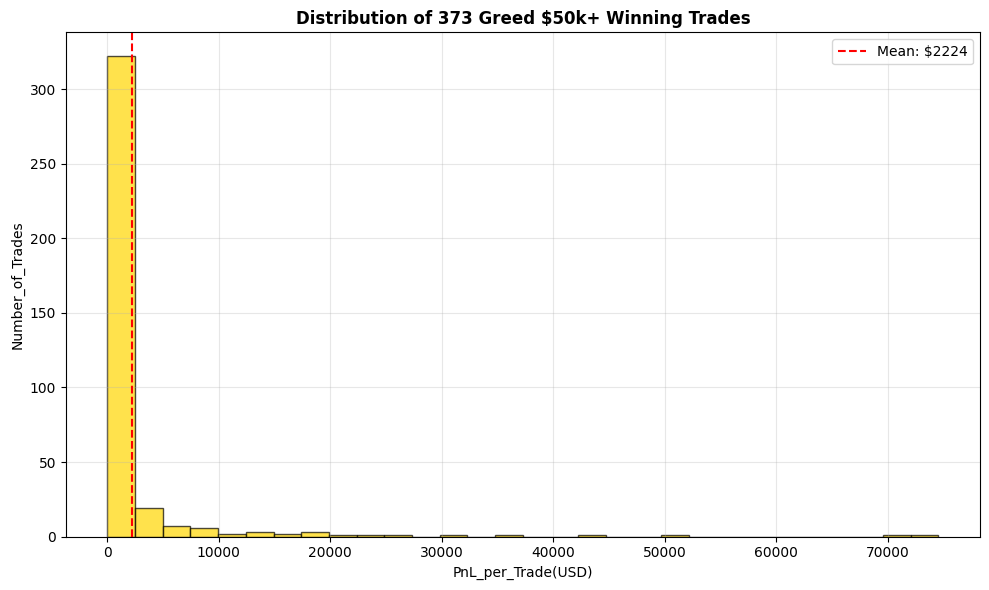

In [84]:
plt.figure(figsize=(10,6))
plt.hist(big_winners['pnl_numeric'], bins=30, color='gold', edgecolor='black', alpha=0.7)
plt.axvline(big_winners['pnl_numeric'].mean(), color='red', linestyle='--', 
           label=f'Mean: ${big_winners["pnl_numeric"].mean():.0f}')
plt.title('Distribution of 373 Greed $50k+ Winning Trades', fontweight='bold')
plt.xlabel('PnL_per_Trade(USD)')
plt.ylabel('Number_of_Trades')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('charts/greed_winners_dist.png', dpi=300, bbox_inches='tight')
plt.show()
